In [1]:
#installing some libraries
!pip install scikeras
!pip install eli5
!pip install keras-spiking

  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikeras 0.13.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


In [2]:
# importing all the essential libraries
import keras_spiking
import numpy as np
import pandas as pd
import csv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
import json
from sklearn.inspection import (partial_dependence,
                                PartialDependenceDisplay)
import matplotlib.pyplot as plt


#reading the PIMA INDIAN DIABETES dataset from the csv.
data = pd.read_csv('diabetes.csv')

#printing dataframe number of rows
print(data.shape)

#print the dataset statistics
# print(data.describe())
# Define features and target variable
X = data.drop(columns='Outcome', axis=1)
y = data['Outcome']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#print all the shapes
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(768, 9)
(614, 8)
(614,)
(154, 8)
(154,)


In [43]:

# Dropping extra rows to get a number divisible by 10
X_train_array = X_train[:610]
X_test_array = X_test[:150]
y_train_array = y_train[:610]
y_test_array = y_test[:150]




In [44]:
ep=50
bs=16
X_test_arr = X_test[:50]
y_test_arr = y_test[:50]

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape,Lambda,Flatten
import keras_spiking

model = Sequential()

# Reshape 2D input data to 3D for the Spiking layer
model.add(Lambda(lambda x: tf.expand_dims(x, axis=1), input_shape=(8,)))  # Adds temporal dimension
model.add(Dense(64,activation='relu'))
# Add the Spiking Layer or any other layers necessary
model.add(keras_spiking.SpikingActivation("relu", dt=1))
# Flatten the 3D output back to 2D before the final output layer
model.add(Flatten())

# Final Dense layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model
history=model.fit(X_train_array, y_train_array, epochs=ep, batch_size=bs, validation_data=(X_test_array, y_test_array))


Epoch 1/50
39/39 [==============================] - 2s 13ms/step - loss: 0.6490 - accuracy: 0.6590 - val_loss: 0.5603 - val_accuracy: 0.7467
Epoch 2/50
39/39 [==============================] - 0s 6ms/step - loss: 0.5545 - accuracy: 0.7262 - val_loss: 0.5180 - val_accuracy: 0.7867
Epoch 3/50
39/39 [==============================] - 0s 6ms/step - loss: 0.5296 - accuracy: 0.7525 - val_loss: 0.4803 - val_accuracy: 0.7533
Epoch 4/50
39/39 [==============================] - 0s 6ms/step - loss: 0.5179 - accuracy: 0.7443 - val_loss: 0.4809 - val_accuracy: 0.7733
Epoch 5/50
39/39 [==============================] - 0s 6ms/step - loss: 0.4926 - accuracy: 0.7721 - val_loss: 0.4839 - val_accuracy: 0.8000
Epoch 6/50
39/39 [==============================] - 0s 6ms/step - loss: 0.4894 - accuracy: 0.7607 - val_loss: 0.4632 - val_accuracy: 0.8000
Epoch 7/50
39/39 [==============================] - 0s 7ms/step - loss: 0.4977 - accuracy: 0.7590 - val_loss: 0.4361 - val_accuracy: 0.8067
Epoch 8/50
39/39 [=

In [38]:
# loaded_model = Sequential()
# loaded_model.add(Lambda(lambda x: tf.expand_dims(x, axis=1), input_shape=(8,)))
# loaded_model.add(Dense(64,activation='relu'))
# loaded_model.add(keras_spiking.SpikingActivation("relu", dt=1))
# loaded_model.add(Flatten())
# loaded_model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
#perform inference on test data
y_pred = model.predict(X_test_arr)
y_pred_binary = (y_pred > 0.5)
print(y_pred_binary)

2/2 [==============================] - 0s 6ms/step
[[ True]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [ True]
 [False]
 [False]
 [False]
 [ True]
 [False]]


In [47]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix_values(z_true, z_pred):
    cm = confusion_matrix(z_true, z_pred)
    return(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

TP, FP, FN, TN = get_confusion_matrix_values(y_test_arr, y_pred_binary)
detection_rate = TP/(TP+FN)
false_alarm_rate = FP/(TN+FP)
accuracy = (TP+TN)/(TP+FP+TN+FN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = (2*precision*recall)/(precision + recall)

print("\n Detection rate = ", detection_rate, "\n")
print("False alarm rate = ", false_alarm_rate, "\n")
print("Accuracy = ", accuracy, "\n")
print("Precision = ", precision, "\n")
print("Recall = ", recall, "\n")
print("F1 = ", F1, "\n")


 Detection rate =  0.8857142857142857 

False alarm rate =  0.2 

Accuracy =  0.86 

Precision =  0.9117647058823529 

Recall =  0.8857142857142857 

F1 =  0.8985507246376812 



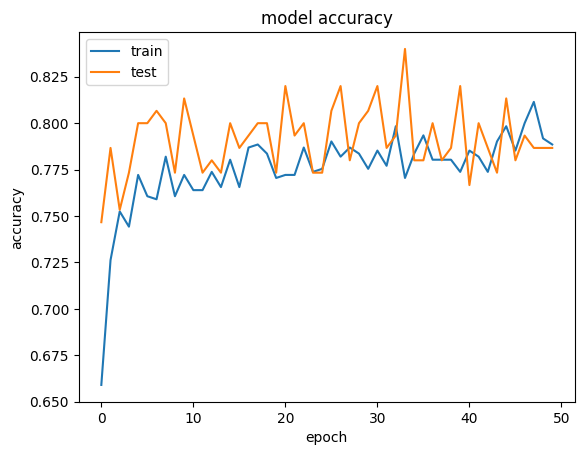

In [48]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

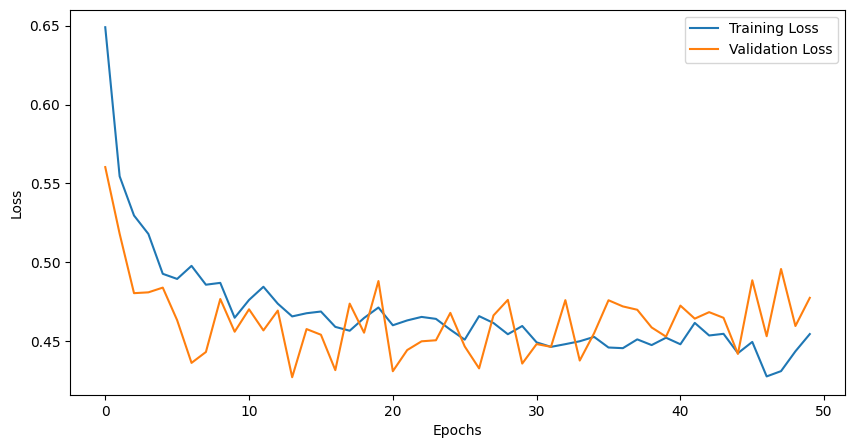

In [49]:


plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
import IPython

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score

# Define a custom scoring function for accuracy
def score(self, X, y, sample_weight=None):
    return accuracy_score(y, (self.predict(X) > 0.5), sample_weight=sample_weight)  # Use appropriate threshold for binary classification

# Create a PermutationImportance object for your SNN model
perm = PermutationImportance(model, score, random_state=1)

# Assuming y_test is the true target labels for the test set
# Fit the PermutationImportance object on the SNN predictions and true labels
perm.fit(X_train_array, y_train_array)

# Display feature importance with eli5
eli5.show_weights(perm,horizontal_layout=True,force_weights=False, feature_names=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])  # Provide feature names if available


ImportError: cannot import name 'if_delegate_has_method' from 'sklearn.utils.metaestimators' (/usr/local/lib/python3.10/dist-packages/sklearn/utils/metaestimators.py)

In [ ]:
!pip install pdfkit
!apt-get install -y wkhtmltopdf


In [ ]:
import pdfkit

In [ ]:

from IPython.display import HTML

html_content = eli5.show_weights(perm, feature_names=['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age'])  # Provide feature names if available


In [ ]:
print(html_content.data)


    <style>
    table.eli5-weights tr:hover {
        filter: brightness(85%);
    }
</style>



    

    

    

    

    

    


    

    

    

    

    

    


    

    

    

    

    
        <table class="eli5-weights eli5-feature-importances" style="border-collapse: collapse; border: none; margin-top: 0em; table-layout: auto;">
    <thead>
    <tr style="border: none;">
        <th style="padding: 0 1em 0 0.5em; text-align: right; border: none;">Weight</th>
        <th style="padding: 0 0.5em 0 0.5em; text-align: left; border: none;">Feature</th>
    </tr>
    </thead>
    <tbody>
    
        <tr style="background-color: hsl(120, 100.00%, 80.00%); border: none;">
            <td style="padding: 0 1em 0 0.5em; text-align: right; border: none;">
                0.1627
                
                    &plusmn; 0.0576
                
            </td>
            <td style="padding: 0 0.5em 0 0.5em; text-align: left; border: none;">
                Glucose
        

In [ ]:
from IPython.core.display import HTML

# Your HTML content with updated colors and reduced width
html_content = """
<style>
    table.eli5-weights {
        width: 50%; /* Adjusted width */
        border-collapse: collapse;
        margin: 0.5em 0; /* Reduced margin space */
        table-layout: fixed;
    }

    table.eli5-weights th, table.eli5-weights td {
        padding: 0.3em; /* Adjusted padding */
        border: 1px solid #ddd; /* Add border to cells */
    }

    table.eli5-weights th {
        text-align: left;
        background-color: #f2f2f2;
    }

    table.eli5-weights tr:hover {
        filter: brightness(85%);
    }
</style>

<table class="eli5-weights eli5-feature-importances">
    <thead>
        <tr>
            <th>Feature</th>
            <th>Weight</th>
        </tr>
    </thead>
    <tbody>
        <tr style="background-color: #FF6F00; color: #ffffff;">
            <td>Glucose</td>
            <td style="text-align: right;">0.1240 &plusmn; 0.0524</td>
        </tr>
        <tr style="background-color: #fca562;">
            <td>BMI</td>
            <td style="text-align: right; color: #ffffff;">0.0213 &plusmn; 0.0331</td>
        </tr>
        <tr style="background-color: #fccb8b;">
            <td>DiabetesPedigreeFunction</td>
            <td style="text-align: right; color: #ffffff;">0.0120 &plusmn; 0.0449</td>
        </tr>
        <tr style="background-color: #FFFAF0;">
            <td>Pregnancies</td>
            <td style="text-align: right; color: #FFE4B5;">0.0040 &plusmn; 0.0364</td>
        </tr>
        <tr style="background-color: #D6EAF8;">
            <td>Age</td>
            <td style="text-align: right; color: #3498DB;">-0.0067 &plusmn; 0.0438</td>
        </tr>
        <tr style="background-color: #5DADE2;">
            <td>Insulin</td>
            <td style="text-align: right; color: #2980B9;">-0.0107 &plusmn; 0.0287</td>
        </tr>
        <tr style="background-color: #3498DB;">
            <td>BloodPressure</td>
            <td style="text-align: right; color: #1F618D;">-0.0120 &plusmn; 0.0196</td>
        </tr>
        <tr style="background-color: #2b91d6;">
            <td>SkinThickness</td>
            <td style="text-align: right; color: #ffffff;">-0.0173 &plusmn; 0.0181</td>
        </tr>
    </tbody>
</table>
"""

# Create and display the HTML object
html_object = HTML(html_content)
html_object


Feature,Weight
Glucose,0.1240 ± 0.0524
BMI,0.0213 ± 0.0331
DiabetesPedigreeFunction,0.0120 ± 0.0449
Pregnancies,0.0040 ± 0.0364
Age,-0.0067 ± 0.0438
Insulin,-0.0107 ± 0.0287
BloodPressure,-0.0120 ± 0.0196
SkinThickness,-0.0173 ± 0.0181


In [ ]:
# Convert the HTML content to a PDF file using pdfkit.
pdfkit.from_string(html_object.data, "/content/output.pdf")

# Download the generated PDF file.
from google.colab import files
files.download('/content/output.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
kr = KerasClassifier(build_fn=model, loss='binary_crossentropy')
kr.fit(X_train,y_train, epochs=20)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


20/20 [==============================] - 1s 3ms/step - loss: 0.4272 - accuracy: 0.7997
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8127
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4208 - accuracy: 0.8013
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4253 - accuracy: 0.8078
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4155 - accuracy: 0.8062
Epoch 6/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4395 - accuracy: 0.7997
Epoch 7/20
20/20 [==============================] - 0s 5ms/step - loss: 0.4134 - accuracy: 0.7980
Epoch 8/20
20/20 [==============================] - 0s 6ms/step - loss: 0.4150 - accuracy: 0.8062
Epoch 9/20
20/20 [==============================] - 0s 3ms/step - loss: 0.4215 - accuracy: 0.8062
Epoch 10/20
20/20 [==============================] - 0s 3ms/step - loss: 0.4141 - accuracy: 0.8029
Epoch 11/20
20/20 [===========

KerasClassifier(
	model=None
	build_fn=<keras.src.engine.sequential.Sequential object at 0x7e20c9319d80>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=binary_crossentropy
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

In [ ]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

5/5 [==============================] - 0s 4ms/step


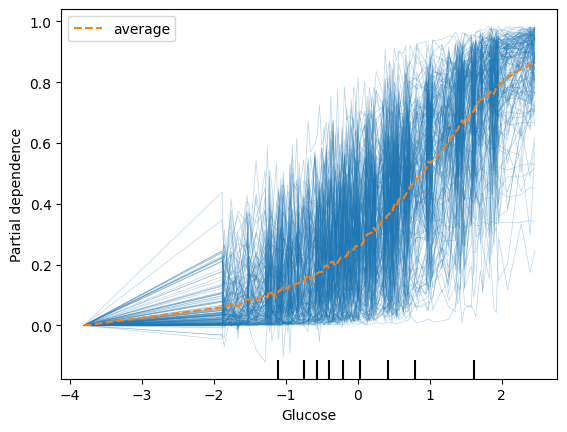

In [ ]:
# use scikeras object on PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(kr, X_test, features = [(1)],feature_names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],kind='both', centered=True)
plt.savefig('Glucose.pdf')

5/5 [==============================] - 0s 3ms/step


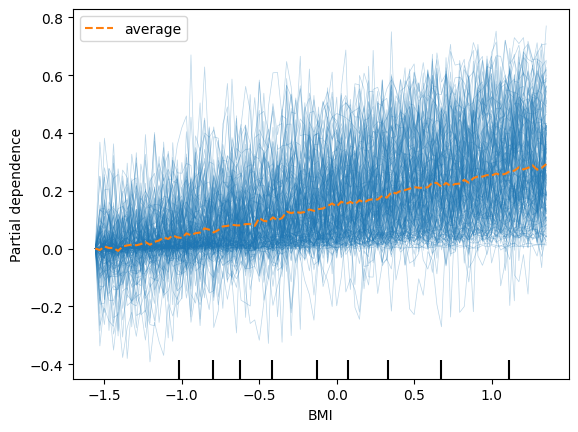

In [ ]:
# use scikeras object on PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(kr, X_test, features = [5],feature_names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],kind='both', centered=True)
plt.savefig('BMI.pdf')

5/5 [==============================] - 0s 3ms/step


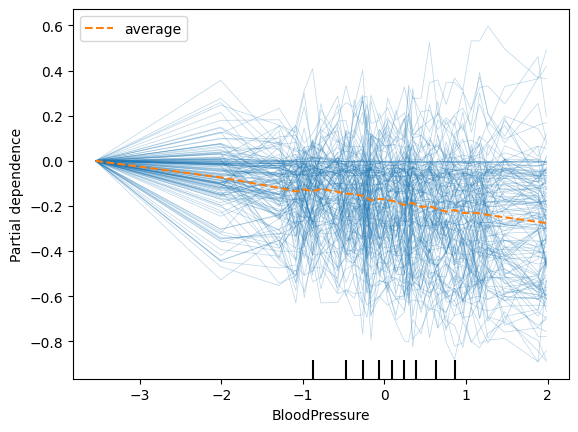

In [ ]:
# use scikeras object on PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(kr, X_test, features = [2],feature_names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],kind='both', centered=True)
plt.savefig('BP.pdf')

5/5 [==============================] - 0s 4ms/step


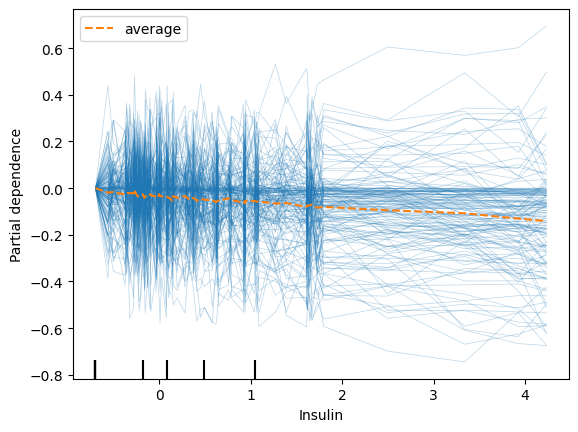

In [ ]:
# use scikeras object on PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(kr, X_test, features = [4],feature_names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],kind='both', centered=True)
plt.savefig('Insulin.pdf')

In [ ]:
X_test_array.shape

(150, 8)

In [ ]:
X_test_array = X_test[:100]
y_test_array = y_test[:100]

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 7.8 MB/s eta 0:00:00


In [ ]:
import shap

# Assuming 'model' is your trained model and 'X_test_array' is your test data
sample=shap.sample(X_test_array,10)
explainer = shap.KernelExplainer(model,sample)



In [ ]:
shap_values = explainer.shap_values(X_test_array)


  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

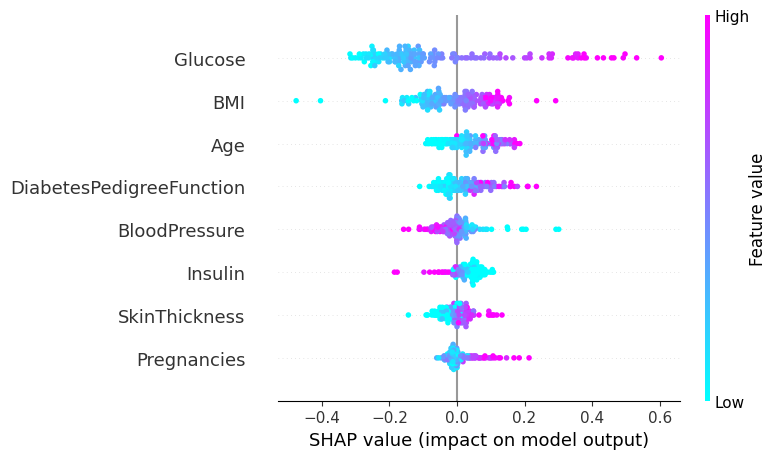

In [ ]:
plt.figure()
cmap = plt.get_cmap("cool")
shap.summary_plot(shap_values[0],X_test_array,feature_names=features,plot_type='dot',show=False)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)
plt.savefig("a.pdf",dpi=150)

In [ ]:
import shap
import matplotlib.pyplot as plt

shap.initjs()

# Create a Shapley force plot
force_plot = shap.force_plot(explainer.expected_value, shap_values[0][0, :], X_test_array[0, :], plot_cmap="RdPu",feature_names=features)

# Save the plot as a PDF
plt.figure()
shap.save_html('force_plot.html', force_plot)


<Figure size 640x480 with 0 Axes>

#OTHER MODELS


In [50]:
# Importing necessary libraries
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
#recheck once on test array:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test,bin=0):
    y_pred = model.predict(X_test)
    if(bin==1):
      y_pred = (y_pred > 0.5)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
    recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
    f1 = 2 * (precision * recall) / (precision + recall)
    return accuracy, precision, recall, f1

# Train and Evaluate Support Vector Machine (SVM)
svm_model = SVC()
svm_model.fit(X_train_array, y_train_array)
svm_accuracy, svm_precision, svm_recall, svm_f1 = evaluate_model(svm_model, X_test_array, y_test_array)
print("SVM Results:")
print(f"Accuracy: {svm_accuracy}")
print(f"Precision: {svm_precision}")
print(f"Recall: {svm_recall}")
print(f"F1 Score: {svm_f1} \n\n")

# Train and Evaluate Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_array, y_train_array)
lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(lr_model, X_test_array, y_test_array)
print("Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy}")
print(f"Precision: {lr_precision}")
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1} \n\n")

# Train and Evaluate Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_array, y_train_array)
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(rf_model, X_test_array, y_test_array)
print("Random Forest Results:")
print(f"Accuracy: {rf_accuracy}")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1} \n\n")

# Train and Evaluate Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train_array, y_train_array)
nb_accuracy, nb_precision, nb_recall, nb_f1 = evaluate_model(nb_model, X_test_array, y_test_array)
print("Naive Bayes Results:")
print(f"Accuracy: {nb_accuracy}")
print(f"Precision: {nb_precision}")
print(f"Recall: {nb_recall}")
print(f"F1 Score: {nb_f1} \n\n")

# Train and Evaluate Naive Bayes
# Build the DNN model
dnnmodel = Sequential()
dnnmodel.add(Dense(64, input_dim=8, activation='relu'))
dnnmodel.add(Dense(1, activation='sigmoid'))

# Compile the model
dnnmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
dnnmodel.fit(X_train_array,  y_train_array, epochs=30, batch_size=16, verbose=1)

dnn_accuracy, dnn_precision, dnn_recall, dnn_f1 = evaluate_model(nb_model, X_test_array, y_test_array)
print("DNN:")
print(f"Accuracy: {dnn_accuracy}")
print(f"Precision: {dnn_precision}")
print(f"Recall: {dnn_recall}")
print(f"F1 Score: {dnn_f1} \n\n")



SVM Results:
Accuracy: 0.7933333333333333
Precision: 0.7027027027027027
Recall: 0.5652173913043478
F1 Score: 0.6265060240963856 


Logistic Regression Results:
Accuracy: 0.82
Precision: 0.7567567567567568
Recall: 0.6086956521739131
F1 Score: 0.674698795180723 


Random Forest Results:
Accuracy: 0.8066666666666666
Precision: 0.7073170731707317
Recall: 0.6304347826086957
F1 Score: 0.6666666666666667 


Naive Bayes Results:
Accuracy: 0.7933333333333333
Precision: 0.6744186046511628
Recall: 0.6304347826086957
F1 Score: 0.651685393258427 


Epoch 1/30
39/39 [==============================] - 3s 7ms/step - loss: 0.6769 - accuracy: 0.5623
Epoch 2/30
39/39 [==============================] - 0s 7ms/step - loss: 0.5904 - accuracy: 0.7082
Epoch 3/30
39/39 [==============================] - 0s 6ms/step - loss: 0.5460 - accuracy: 0.7377
Epoch 4/30
39/39 [==============================] - 0s 6ms/step - loss: 0.5181 - accuracy: 0.7508
Epoch 5/30
39/39 [==============================] - 0s 5ms/step - 